# prep

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import scipy.io as sio
from tqdm import tqdm
import os
import pickle
%load_ext autoreload
%autoreload 2

In [2]:
local_flag = False
if local_flag:
    repo_dir = r'D:\repo\inter_data\inter'.replace("\\", "/") # under env dimred
else:
    repo_dir = r'C:\Users\ll357\Documents\inter'.replace("\\", "/")
os.chdir(repo_dir)
from src import adp

# batch process df_tidy (no need to run this)

## batch write df_tidy
rewrite all grat SF data, from me or lindsey, to bin SF to SF_ref

In [3]:
SF_ref = np.logspace(1, 6, num=6, base=2)/100
SF_ref

array([0.02, 0.04, 0.08, 0.16, 0.32, 0.64])

In [30]:
mode = 'map to ref SF'

mat_inter_path = r'\\duhs-user-nc1.dhe.duke.edu\dusom_glickfeldlab\All_Staff\home\lan\Data\2P_images\mat_inter/'.replace('\\', '/')
meta = pd.read_excel(mat_inter_path + 'adp_dataset_master.xlsx')
meta = meta[(meta.paradigm == 'grat_SF_lindsey') | (meta.paradigm == 'grat_SF6')]
meta = meta[~meta.note.str.contains('bad', na=False)] # exclude bad sessions
meta['date_sess'] = meta.date.astype(str) + '_00' + meta.num.astype(str)
meta

for date_sess in meta.date_sess.unique(): # date-sess combo is unique. loop over sessions, not dates, to account for multi sessions on same day # edit: actually, df_tidy is built from trace_trial_stim.mat, which already merged multisess. so loop over dates is fine too
    print(date_sess)
    
    mouse_now = meta[meta.date_sess == date_sess].mouse.unique()[0].astype(str)
    date_now = meta[meta.date_sess == date_sess].date.unique()[0].astype(str)
    sess_now = '00' + meta[meta.date_sess == date_sess].num.unique()[0].astype(str)
    paradigm_now = meta[meta.date_sess == date_sess].paradigm.unique()[0]
    print(mouse_now, date_now, sess_now, paradigm_now)
    
    ## load data
    dir_data = r'\\duhs-user-nc1.dhe.duke.edu\dusom_glickfeldlab\All_Staff\home\lan\Data\2P_images\mat_inter/'
    if paradigm_now == 'grat_SF_lindsey':
        dir_data += f'V1_i{mouse_now}_{date_now}_lindsey'
    elif paradigm_now == 'grat_SF6':
        dir_data += f'V1_i{mouse_now}_{date_now}_cellpose'    
    stim_id, trace_by_trial = adp.load_trace_trial_data(os.path.join(dir_data), vis_filter=False)
    if np.min(stim_id[0]) == 1: # stim id was 1-based index
        stim_id[0] -= 1 # stim id adjusted to 0-based index
    assert np.min(stim_id[0]) == 0

    base1 = trace_by_trial[:,:,0:2+1].mean(axis=2) # avg over time window frames
    resp_ad = trace_by_trial[:,:,9:11+1].mean(axis=2)
    resp_ad = resp_ad - base1
    base2 = trace_by_trial[:,:,13:14+1].mean(axis=2)
    resp_tg = trace_by_trial[:,:,20:22+1].mean(axis=2)
    resp_tg = resp_tg - base2

    ## merge SF
    if paradigm_now == 'grat_SF_lindsey':
        dir_data_now = os.path.join(
            r'\\duhs-user-nc1.dhe.duke.edu\dusom_glickfeldlab\All_Staff\home\lindsey\Analysis\2P/'.replace("\\", "/"),
            str(date_now) + r'_i' + str(mouse_now),
            str(date_now) + r'_i' + str(mouse_now) + r'_runs-' + str(2).zfill(3) # only sess 002 is usable from lindsey's data
        )
        input_mworks = [file for file in os.listdir(dir_data_now) if file.endswith("_input.mat")][0]
        input_mworks = sio.loadmat(os.path.join(dir_data_now, input_mworks))
        SF_cpd = input_mworks['input']['tStimOneGratingSpatialFreqCPD'][0][0][0]
        SF_flat = np.array([SF_cpd[i][0][0] for i in range(len(SF_cpd))])
        SF_now = np.unique(SF_flat)

    elif paradigm_now == 'grat_SF6':
        dir_data_now = os.path.join(
            r'\\duhs-user-nc1.dhe.duke.edu\dusom_glickfeldlab\All_Staff\home\lan\Analysis\2P/'.replace("\\", "/"),
            date_now + r'_i' + mouse_now,
            date_now + r'_i' + mouse_now + r'_runs-' + sess_now
        )
        input_mworks = [file for file in os.listdir(dir_data_now) if file.endswith("_input.mat")][0]
        input_mworks = sio.loadmat(os.path.join(dir_data_now, input_mworks))
        SF_cpd = input_mworks['behav_input']['tStimOneGratingSpatialFreqCPD'][0][0][0]
        SF_flat = np.array([SF_cpd[i][0][0] for i in range(len(SF_cpd))])
        SF_now = np.unique(SF_flat)
    
    ## map stim_id to ref stim_id
    print(np.round(SF_ref, 2))
    stim_dict = {}
    for (iSF, SF_cpd) in enumerate(SF_now):
        print(iSF, np.round(SF_cpd, 2), np.argmin(np.abs(SF_ref - SF_cpd)))
        stim_dict[iSF] = np.argmin(np.abs(SF_ref - SF_cpd))
    # print(stim_dict) # key: current data's stim_id, value: mapped to ref stim_id
    stim_id_mapped = np.array([stim_dict[i] for i in stim_id[0]])

    ## df tidy
    R1_dfof = resp_ad.flatten() # cell x trial, row major flatten
    R2_dfof = resp_tg.flatten()
    dfof = np.hstack((R1_dfof, R2_dfof))

    ncell = resp_ad.shape[0]
    ntrial = resp_ad.shape[1]
    cell_id = np.repeat(np.arange(ncell), ntrial)
    cell_id = np.hstack((cell_id, cell_id)) # stack two copies for R1 and R2

    trial_id = np.tile(np.arange(ntrial), ncell)
    trial_id = np.hstack((trial_id, trial_id))

    print(f'{mode} mode')
    if mode == 'map to ref SF':
        stim_id_col = np.tile(stim_id_mapped, ncell)
        stim_id_ori = np.tile(stim_id[0], ncell)
        stim_id_ori = np.hstack((stim_id_ori, stim_id_ori)) # keep record of original stim_id in lindsey's data, to match img_driven (filter_cell_stim)
    else:
        stim_id_col = np.tile(stim_id[0], ncell)
    stim_id_col = np.hstack((stim_id_col, stim_id_col))

    len_df = ncell * ntrial * 2 # 2 for (R1, R2)
    resp_id = ['R1'] * (len_df//2) + ['R2'] * (len_df//2) # first half is flattened resp_ad, second half is flattened resp_tg

    df_tidy = pd.DataFrame({'dfof': dfof, 'cell_id': cell_id, 'trial_id': trial_id, 'stim_id': stim_id_col, 'resp_id': resp_id})
    if mode == 'map to ref SF':
        df_tidy['stim_id_ori'] = stim_id_ori

    ## trial filter
    trial_filter_file = [f for f in os.listdir(dir_data) if f.__contains__('filter_trials_')]

    trial_ok = np.array([])
    for file in trial_filter_file:
        trial_filter = sio.loadmat(os.path.join(dir_data, file))
        trial_eye_ok = trial_filter['trial_eye_ok']
        trial_eye_ok = np.array([i[0] for i in trial_eye_ok], dtype=bool)
        trial_speed_ok = trial_filter['trial_speed_ok']
        trial_speed_ok = np.array([i[0] for i in trial_speed_ok], dtype=bool)
        trial_ok_sess = trial_eye_ok & trial_speed_ok
        trial_ok_sess = trial_ok_sess[:-1] # remove the last trial, which is not a full trial
        trial_ok = np.append(trial_ok, trial_ok_sess)

    trial_ok = np.array(trial_ok, dtype=bool)
    assert len(trial_ok) == trace_by_trial.shape[1]

    filter_trial = np.tile(trial_ok, ncell)
    filter_trial = np.hstack((filter_trial, filter_trial))
    df_tidy['filter_trial'] = filter_trial

    ## cell filter
    df_tidy['filter_cell'] = np.nan
    df_tidy['filter_cell_stim'] = np.nan

    with open(os.path.join(dir_data, 'vis_driven.pickle'), 'rb') as f:
        filter_file = pickle.load(f)
    filter_cell_stim = filter_file['img_driven']
    filter_cell = filter_file['vis_driven']

    print(f'ncell = {filter_cell_stim.shape[0]}, nstim = {filter_cell_stim.shape[1]}')
    for icell in np.arange(filter_cell_stim.shape[0]):
        df_tidy.loc[df_tidy['cell_id']==icell, 'filter_cell'] = filter_cell[icell][0] # filter_cell is a list of list
        for istim in np.arange(filter_cell_stim.shape[1]):
            df_tidy.loc[(df_tidy['stim_id_ori']==istim) & (df_tidy['cell_id']==icell), 'filter_cell_stim'] = filter_cell_stim[icell, istim]
    
    df_tidy.to_csv(os.path.join(dir_data, 'df_tidy_inherit_respwin.csv'), index=False)
    print('------------')
    # break

230103_002
1375 230103 002 grat_SF6
ncell: 91, nstim: 6, ntrial: 1012, nframe: 197
[0.02 0.04 0.08 0.16 0.32 0.64]
0 0.06 1
1 0.11 2
2 0.19 3
3 0.34 4
4 0.6 5
5 1.08 5
map to ref SF mode
ncell = 91, nstim = 6
------------
230103_003
1375 230103 003 grat_SF6
ncell: 91, nstim: 6, ntrial: 1012, nframe: 197
[0.02 0.04 0.08 0.16 0.32 0.64]
0 0.06 1
1 0.11 2
2 0.19 3
3 0.34 4
4 0.6 5
5 1.08 5
map to ref SF mode
ncell = 91, nstim = 6
------------
230127_003
1380 230127 003 grat_SF6
ncell: 103, nstim: 6, ntrial: 1641, nframe: 197
[0.02 0.04 0.08 0.16 0.32 0.64]
0 0.06 1
1 0.11 2
2 0.19 3
3 0.34 4
4 0.6 5
5 1.08 5
map to ref SF mode
ncell = 103, nstim = 6
------------
230127_004
1380 230127 004 grat_SF6
ncell: 103, nstim: 6, ntrial: 1641, nframe: 197
[0.02 0.04 0.08 0.16 0.32 0.64]
0 0.06 1
1 0.11 2
2 0.19 3
3 0.34 4
4 0.6 5
5 1.08 5
map to ref SF mode
ncell = 103, nstim = 6
------------
230127_005
1380 230127 005 grat_SF6
ncell: 103, nstim: 6, ntrial: 1641, nframe: 197
[0.02 0.04 0.08 0.16 0.3

## batch load df_tidy
across mouse, date, session

In [32]:
date_unique = meta.date.unique()
df_tidy = pd.DataFrame()

for idate in date_unique: # df_tidy is built from trace_trial_stim.mat, which already merged multisess. so loop over dates is fine
    data_meta_sess = meta[meta.date == idate]
    print(f'{idate}: {len(data_meta_sess)} sessions')

    mouse = meta[meta.date == idate].mouse.unique()[0]
    print(f'mouse {mouse}, depth {data_meta_sess.depth.unique()[0]}')

    dir_data = r'\\duhs-user-nc1.dhe.duke.edu\dusom_glickfeldlab\All_Staff\home\lan\Data\2P_images\mat_inter/'

    try:
        dir_exp = dir_data + f'V1_i{mouse}_{idate}_cellpose'
        # df_tidy_date = pd.read_csv(os.path.join(dir_exp, 'df_tidy.csv'))
        df_tidy_date = pd.read_csv(os.path.join(dir_exp, 'df_tidy_ref_SF_yuansi.csv'))
    except:
        dir_exp = dir_data + f'V1_i{mouse}_{idate}_lindsey'
        df_tidy_date = pd.read_csv(os.path.join(dir_exp, 'df_tidy_ref_SF_yuansi.csv'))

    df_tidy_date['mouse'] = mouse
    df_tidy_date['date'] = idate
    df_tidy_date['cell_id'] = df_tidy_date.date * 1000 + df_tidy_date.cell_id # cell_id adjusted to be unique across mice and dates. we know ncell < 1000 for each mouse and date
    df_tidy = pd.concat([df_tidy, df_tidy_date], axis=0).reset_index(drop=True)

230103: 2 sessions
mouse 1375, depth 150.0
230127: 3 sessions
mouse 1380, depth 150.0
230209: 3 sessions
mouse 1375, depth 200.0
230214: 3 sessions
mouse 1373, depth 150.0
220526: 1 sessions
mouse 1369, depth nan
220529: 1 sessions
mouse 1372, depth nan
220530: 1 sessions
mouse 1370, depth nan
220619: 1 sessions
mouse 1369, depth nan
220620: 1 sessions
mouse 1370, depth nan
220623: 1 sessions
mouse 1372, depth nan


## batch save merged df_tidy

In [34]:
df_tidy.sample(10)

df_tidy.to_csv(os.path.join(mat_inter_path, 'df_tidy_ref_SF_yuansi_merged.csv'), index=False)

# load merged df_tidy

In [38]:
mat_inter_path = r'\\duhs-user-nc1.dhe.duke.edu\dusom_glickfeldlab\All_Staff\home\lan\Data\2P_images\mat_inter/'.replace('\\', '/')
df_tidy = pd.read_csv(os.path.join(mat_inter_path, 'df_tidy_ref_SF_yuansi_merged.csv'))

# filter data

## filter cell by SNR (deprecated, no need to run this)

100%|██████████| 1450/1450 [03:41<00:00,  6.54it/s]


snr_thres: 0.30


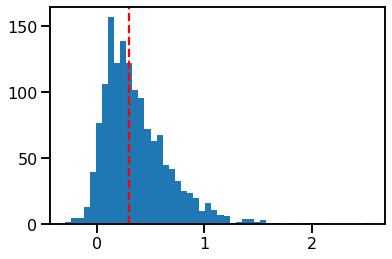

In [35]:
snr_cell_arr = np.array([])

for icell in tqdm(df_tidy.cell_id.unique()):
    df_cell = df_tidy[(df_tidy.cell_id == icell) & (df_tidy.resp_id == 'R1')] # only calc R1 SNR
    signal = df_cell.groupby(['stim_id'])['dfof'].mean()
    noise = df_cell.groupby(['stim_id'])['dfof'].std()
    snr = signal / noise # single cell snr of each stim
    snr_cell = np.median(snr) # median snr across all stims
    snr_cell_arr = np.append(snr_cell_arr, snr_cell)

snr_thres = np.percentile(snr_cell_arr, 50)
print(f'snr_thres: {snr_thres:.2f}')

plt.hist(snr_cell_arr, bins=50);
plt.axvline(snr_thres, color='r', linestyle='--');

In [36]:
df_tidy['filter_cell_snr'] = False
for (icell, cell_id) in enumerate(df_tidy.cell_id.unique()):
    snr_cell = snr_cell_arr[icell]
    if snr_cell >= snr_thres:
        df_tidy.loc[df_tidy.cell_id == cell_id, 'filter_cell_snr'] = True

try:
    import math
    assert math.isclose(0.5, df_tidy.filter_cell_snr.sum() / len(df_tidy), abs_tol=0.01)
except:
    print(df_tidy.filter_cell_snr.sum() / len(df_tidy))

df_tidy

0.5240020356181377


,dfof,cell_id,trial_id,stim_id,resp_id,stim_id_ori,filter_trial,filter_cell,filter_cell_stim,mouse,date,filter_cell_snr
0,-0.133319,230103000,0,5,R1,4,True,True,False,1375,230103,True
1,0.113303,230103000,1,3,R1,2,True,True,True,1375,230103,True
2,-0.018100,230103000,2,3,R1,2,True,True,True,1375,230103,True
3,-0.032178,230103000,3,4,R1,3,True,True,True,1375,230103,True
4,-0.065120,230103000,4,3,R1,2,True,True,True,1375,230103,True
...,...,...,...,...,...,...,...,...,...,...,...,...
3088983,-0.023467,220623119,640,1,R2,1,True,True,False,1372,220623,False
3088984,0.015559,220623119,641,4,R2,8,False,True,False,1372,220623,False
3088985,-0.109568,220623119,642,2,R2,3,False,True,False,1372,220623,False
3088986,-0.038351,220623119,643,4,R2,8,False,True,False,1372,220623,False


## filter cell by visually driven

In [39]:
df_filter = df_tidy[df_tidy['filter_cell'] # vis driven filter
                    # & df_tidy['filter_cell_stim'] # img driven filter
                    # & df_tidy['filter_cell_snr'] # snr filter
                    # & df_tidy['filter_trial']
                    ]
df_filter

,dfof,cell_id,trial_id,stim_id,resp_id,stim_id_ori,filter_trial,filter_cell,filter_cell_stim,mouse,date
0,-0.133319,230103000,0,5,R1,4,True,True,False,1375,230103
1,0.113303,230103000,1,3,R1,2,True,True,True,1375,230103
2,-0.018100,230103000,2,3,R1,2,True,True,True,1375,230103
3,-0.032178,230103000,3,4,R1,3,True,True,True,1375,230103
4,-0.065120,230103000,4,3,R1,2,True,True,True,1375,230103
...,...,...,...,...,...,...,...,...,...,...,...
3088983,-0.023467,220623119,640,1,R2,1,True,True,False,1372,220623
3088984,0.015559,220623119,641,4,R2,8,False,True,False,1372,220623
3088985,-0.109568,220623119,642,2,R2,3,False,True,False,1372,220623
3088986,-0.038351,220623119,643,4,R2,8,False,True,False,1372,220623


## filter cell-stim combination by preference

In [40]:
df_pref = df_filter.copy()
df_pref['filter_pref'] = False

# for each cell, find the stim with the largest resp
for icell in df_filter.cell_id.unique():
    df_cell = df_pref[df_pref['cell_id']==icell]
    df_cell = df_cell[df_cell['resp_id']=='R1'] # only use R1
    if len(df_cell) == 0:
        continue
    df_cell = df_cell.groupby(['stim_id'])['dfof'].mean().reset_index() # mean dfof of each stim
    df_cell = df_cell.sort_values(by='dfof', ascending=False) # sort by dfof, largest first
    pref_stim = df_cell.iloc[0]['stim_id'].astype(int) # stim id of the largest resp
    df_pref.loc[(df_pref['cell_id']==icell) & (df_pref['stim_id']==pref_stim), 'filter_pref'] = True
df_pref

df_pref = df_pref[df_pref['filter_pref']] # only retain preferred stim x cell combo

,dfof,cell_id,trial_id,stim_id,resp_id,stim_id_ori,filter_trial,filter_cell,filter_cell_stim,mouse,date,filter_pref
0,-0.133319,230103000,0,5,R1,4,True,True,False,1375,230103,False
1,0.113303,230103000,1,3,R1,2,True,True,True,1375,230103,True
2,-0.018100,230103000,2,3,R1,2,True,True,True,1375,230103,True
3,-0.032178,230103000,3,4,R1,3,True,True,True,1375,230103,False
4,-0.065120,230103000,4,3,R1,2,True,True,True,1375,230103,True
...,...,...,...,...,...,...,...,...,...,...,...,...
3088983,-0.023467,220623119,640,1,R2,1,True,True,False,1372,220623,False
3088984,0.015559,220623119,641,4,R2,8,False,True,False,1372,220623,False
3088985,-0.109568,220623119,642,2,R2,3,False,True,False,1372,220623,False
3088986,-0.038351,220623119,643,4,R2,8,False,True,False,1372,220623,False


### tuning curve of neurons with diff SF pref

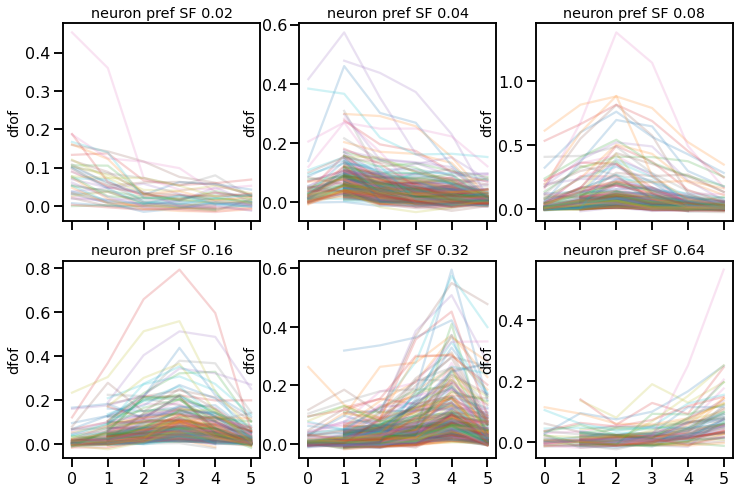

In [41]:
nstim = len(df_pref.stim_id.unique())
fig, ax = plt.subplots(nrows=2, ncols=nstim//2, figsize=(12, 8), sharex=True) # , sharey=True
# for each stim, draw on a subplot

for istim in sorted(df_pref.stim_id.unique()):
    # get cells who prefer this stim
    df_pref_istim = df_pref[(df_pref.stim_id == istim) & (df_pref.filter_pref == True)]

    for icell in df_pref_istim.cell_id.unique():
    # for icell in df_pref_istim.cell_id.sample(50, random_state=42).unique():
        df_pref_icell = df_pref[df_pref.cell_id == icell]
        stim_arr = df_pref_icell.groupby(['stim_id'])['dfof'].mean().index.values
        resp_arr = df_pref_icell.groupby(['stim_id'])['dfof'].mean().values

        ax[istim//3, istim%3].plot(stim_arr, resp_arr, alpha=0.2)
        SF_ref = np.logspace(1, 6, num=6, base=2) / 100 # 0.02-0.64 cpd
        ax[istim//3, istim%3].set_title(f'neuron pref SF {SF_ref[istim]}')
        ax[istim//3, istim%3].set_xticks(stim_arr)
        ax[istim//3, istim%3].set_ylabel('dfof')

# Adaptation vs preferred SF

In [43]:
# output should be of shape: nboot x nstim x ncell
# for each bootstrap, for each stim x cell, randomly select nrep trials

nboot = 1000
nrep_selected = 30 # dictated by grat1 adp stability test
seed_arr = np.random.randint(0, 100, size=nboot) # get random seed for each bootstrap

adp_boot = []
for iboot in tqdm(np.arange(nboot)):
    R1_agg = (df_pref[(df_pref['resp_id']=='R1')]
                    .groupby(['stim_id', 'cell_id'])['dfof']
                    .apply(lambda x: x.sample(n=nrep_selected, replace=True, 
                                              random_state=seed_arr[iboot]) # select same trial reps for R1 and R2
                    .mean())
                    .reset_index()['dfof'].values) # for each stim x cell, randomly select nrep trials resp, take sum
    R2_agg = (df_pref[(df_pref['resp_id']=='R2')]
                    .groupby(['stim_id', 'cell_id'])['dfof']
                    .apply(lambda x: x.sample(n=nrep_selected, replace=True, 
                                              random_state=seed_arr[iboot])
                    .mean())
                    .reset_index()['dfof'].values)
    
    # adp_agg = (R2_agg - R1_agg) / (R2_agg + R1_agg + 1e-7) # IOU version
    adp_agg = (R2_agg - R1_agg) / (R1_agg + 1e-7) # diff over R1 version
    
    adp_agg[np.abs(adp_agg) > 5] = np.nan # remove outliers
    # adp_agg[np.abs(R2_agg + R1_agg) < 0.1] = np.nan
    # adp_agg[np.abs(R1_agg) < 0.01] = np.nan
    
    adp_boot.append(adp_agg)

print('adp hard thresholding')

adp_boot = np.array(adp_boot)

100%|██████████| 1000/1000 [16:34<00:00,  1.01it/s]

adp hard thresholding


In [46]:
# adp_boot shape = nboot x (nstim x ncell, preferred)

df_adp_pref = (df_pref[(df_pref['resp_id']=='R1')]
                .groupby(['stim_id', 'cell_id'])['dfof']
                .apply(lambda x: x.sample(n=nrep_selected, replace=True).sum()) # dfof col was not used
                .reset_index())

# agg_method = np.nanmedian
agg_method = np.nanmean

adp_boot_agg = agg_method(adp_boot, axis=0) # sum over all bootstraps
df_adp_pref['adp_pref'] = adp_boot_agg

df_adp_pref = df_adp_pref.dropna(subset=['adp_pref']) # remove nan, which is adp outliers
df_adp_pref.tail(), df_adp_pref.shape, df_adp_pref.stim_id.max()

(      stim_id    cell_id      dfof  adp_pref
 1330        5  230103011  0.710457  0.101033
 1331        5  230127005  1.166710 -0.633428
 1332        5  230127030  1.071474  0.333790
 1333        5  230127037  0.332745  0.800437
 1334        5  230127053  2.101202 -0.259627,
 (1335, 4),
 5)

## boxplot across cells
for each SF, take cells that prefer this grating SF. boxplot errorbar is across cells

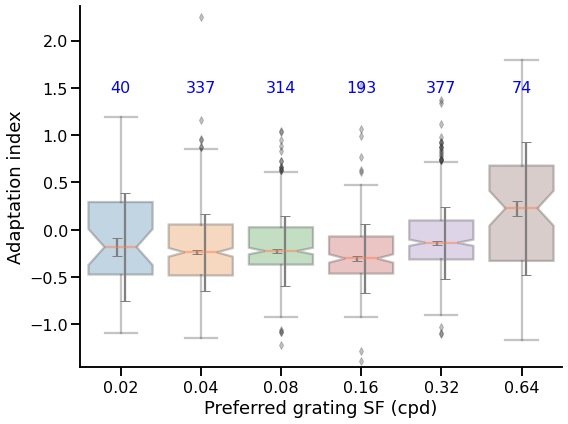

In [57]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(x='stim_id', y='adp_pref', data=df_adp_pref, ax=ax, 
            notch=True, 
            boxprops=dict(alpha=.3), 
            whiskerprops=dict(alpha=.3),
            capprops=dict(alpha=.3),
            flierprops=dict(alpha=.3),
            medianprops={"color": "coral", "alpha": .5},
            meanprops={"color": "orange"},)
# sns.swarmplot(x='stim_id', y='adp_pref', data=df_adp_pref, ax=ax, alpha=0.5) # set figsize to (18, 6) for swarmplot

adp_pref_agg = df_adp_pref.groupby('stim_id')['adp_pref'].median().values # or use mean()
adp_pref_std = df_adp_pref.groupby('stim_id')['adp_pref'].std().values
adp_pref_sem = df_adp_pref.groupby('stim_id')['adp_pref'].sem().values
ax.errorbar(np.arange(adp_pref_agg.shape[0])+0.05, adp_pref_agg,
            yerr=adp_pref_std, fmt='none', color='gray', capsize=5)
ax.errorbar(np.arange(adp_pref_agg.shape[0])-0.05, adp_pref_agg,
            yerr=adp_pref_sem, fmt='none', color='gray', capsize=5)

ncell_SF = df_adp_pref.groupby('stim_id')['cell_id'].nunique().values # ncell for each stim_id
for i, ncell_iSF in enumerate(ncell_SF):
    ncell_iSF = int(ncell_iSF)
    ax.text(i, 1.5, ncell_iSF, ha='center', va='center', fontsize=16, color='blue')

SF_ref = np.logspace(1, 6, num=6, base=2)/100 # 0.02-0.64 cpd. this should be updated to match # batch rewrite df tidy
cpd_array = np.round(SF_ref, 2)
ax.set_xticklabels(cpd_array)
ax.set_xlabel('Preferred grating SF (cpd)', fontsize=18)
ax.set_ylabel('Adaptation index', fontsize=18)
ax.set_ylim([np.nanmin(df_adp_pref['adp_pref'].values * 1.05), np.nanmax(df_adp_pref['adp_pref'].values * 1.05)])

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
fig.tight_layout()
# dir_fig = r'C:\Users\ll357\Documents\inter\results\joint lab meeting 2023-03'.replace('\\', '/')
# fig.savefig(os.path.join(dir_fig, 'adp_pref_grat_SF6_diff_over_R1.pdf'), bbox_inches='tight')